In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
train = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\test.csv', parse_dates=['date'])
sample_sub = pd.read_csv(r'C:\Users\gmjj0\Downloads\Store Item Demand Forecasting\sample_submission.csv')
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))
train.head()

Train shape:(913000, 4), Test shape:(45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [33]:
print("number of unique items :",train.item.nunique())
print("number of unique store :",train.store.nunique())

number of unique items : 50
number of unique store : 10


In [34]:
train['dayofmonth'] = train.date.dt.day
train['dayofyear'] = train.date.dt.dayofyear
train['dayofweek'] = train.date.dt.dayofweek
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['weekofyear'] = train.date.dt.weekofyear
train.head()

,date,store,item,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
0,2013-01-01,1,1,13,1,1,1,1,2013,1
1,2013-01-02,1,1,11,2,2,2,1,2013,1
2,2013-01-03,1,1,14,3,3,3,1,2013,1
3,2013-01-04,1,1,13,4,4,4,1,2013,1
4,2013-01-05,1,1,10,5,5,5,1,2013,1


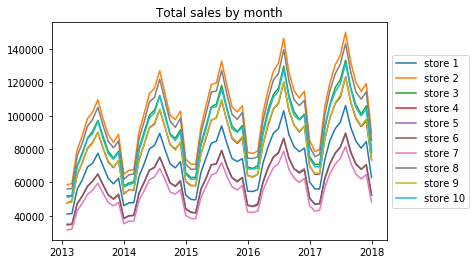

In [ ]:
for i in range(1,11):
    month_df = train[train.store==i].resample('M',on='date').sum()
    x= np.array(month_df.index)
    y=np.array(month_df.sales)
    plt.plot(x,y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total sales by month")
plt.show()

Text(0.5, 1.0, 'Store/ Item sales heatmap')

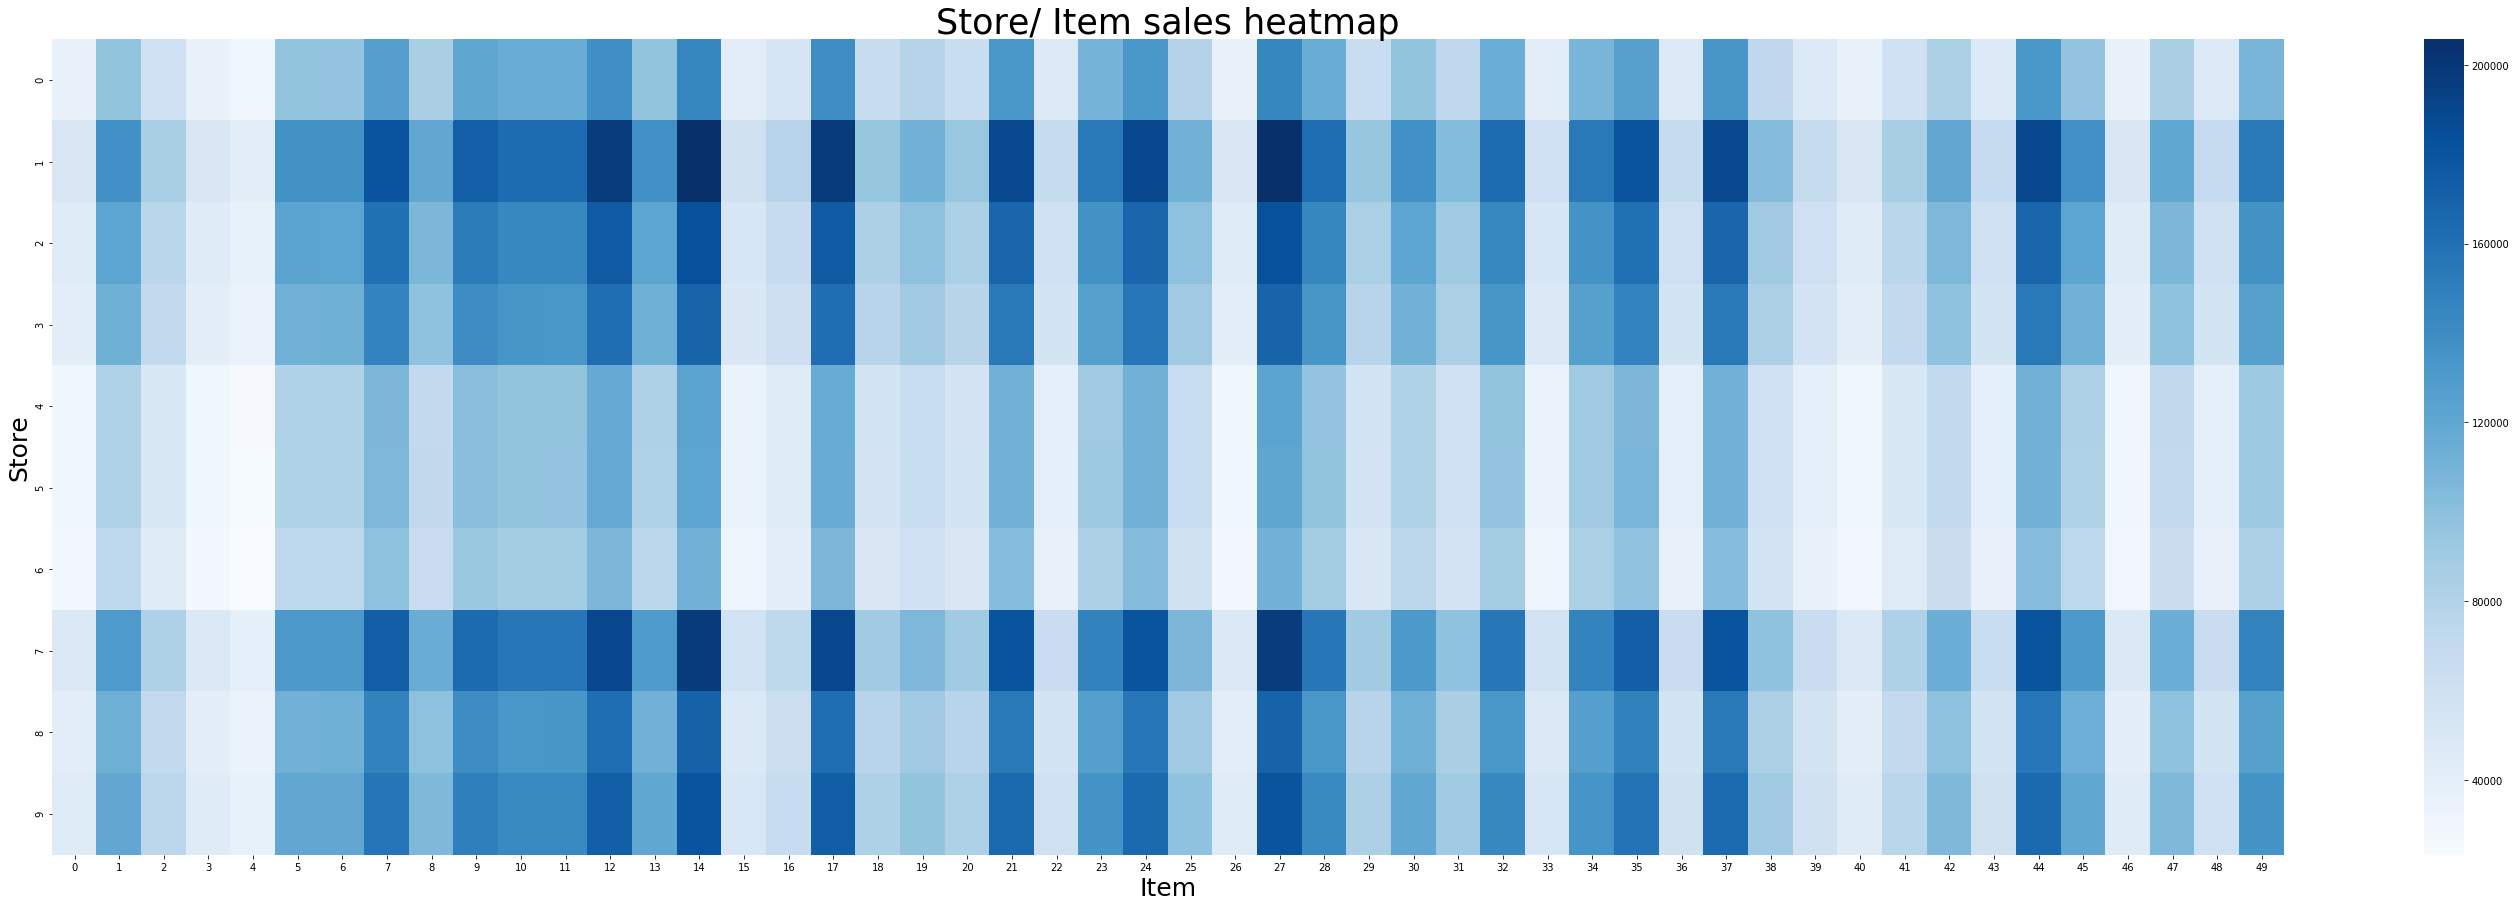

In [ ]:
store_item_df = train.groupby(['store','item']).sum()
matrixStoreItem = np.zeros((10,50))
for i in range(1,11):
    for j in range(1,51):
        matrixStoreItem[i-1,j-1] = store_item_df.loc[i,j].sales

plt.figure(figsize=(50,15))
ax = sns.heatmap(matrixStoreItem,cmap='Blues')
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Store",fontsize=25)
plt.title("Store/ Item sales heatmap",fontsize=35)

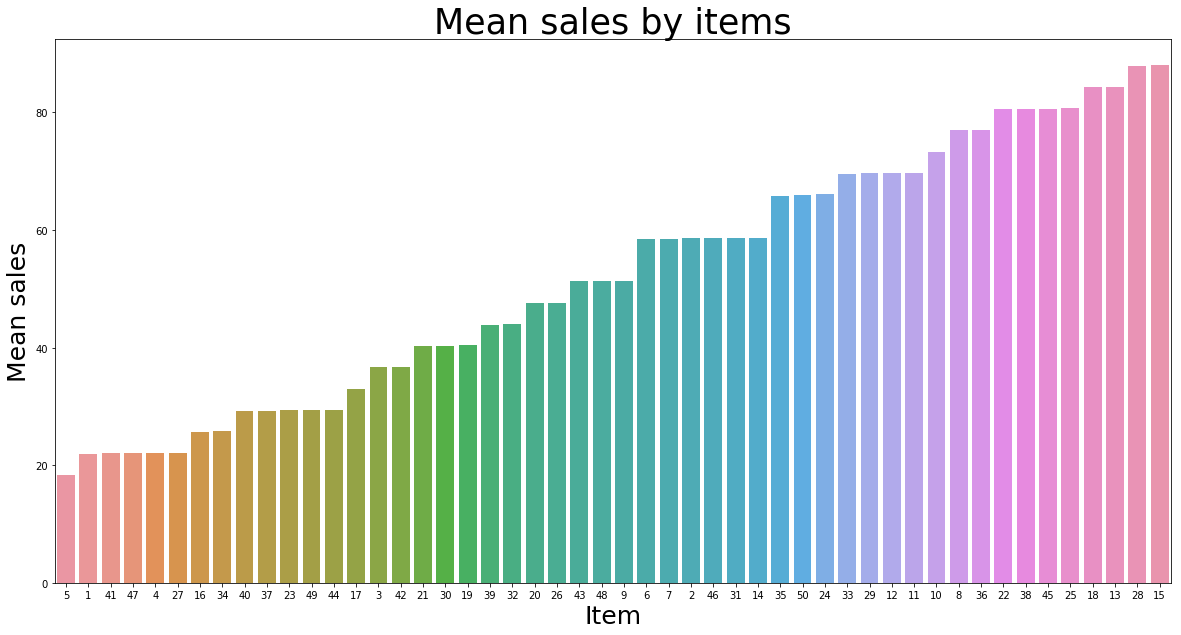

In [ ]:
plt.close('all')
item_df = train.groupby(['item']).mean()
item_df.sort_values('sales',ascending=True,inplace=True)
x = item_df.index
y = item_df.sales
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y, order=x)
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Mean sales",fontsize=25)
plt.title("Mean sales by items",fontsize=35)
plt.show()

In [ ]:
df = pd.get_dummies(train, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df.head()

,date,sales,dayofyear,year,store_1,store_2,store_3,store_4,store_5,store_6,...,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,weekofyear_53
0,2013-01-01,13,1,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11,2,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14,3,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13,4,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10,5,2013,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]
print("train shape: ",df_train.shape)
print("validation shape :",df_val.shape)

train shape:  (730320, 167)
validation shape : (182680, 167)


In [ ]:
df_train.drop('date',axis=1,inplace=True)
df_val.drop('date',axis=1,inplace=True)
y_train = df_train['sales'].values
y_test = df_val['sales'].values
X_train = df_train.drop('sales', axis=1).values
X_test = df_val.drop('sales', axis=1).values

C:\Users\gmjj0\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': {'rmse'}, 'num_leaves': 10, 'learning_rate': 0.05, 
              'feature_fraction': 0.8, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':100, 'nthread':-1}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

C:\Users\gmjj0\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\gmjj0\Anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 28.6193
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 28.3925
[3]	valid_0's rmse: 28.2092
[4]	valid_0's rmse: 27.9951
[5]	valid_0's rmse: 27.8162
[6]	valid_0's rmse: 27.6303
[7]	valid_0's rmse: 27.433
[8]	valid_0's rmse: 27.2495
[9]	valid_0's rmse: 27.0819
[10]	valid_0's rmse: 26.9291
[11]	valid_0's rmse: 26.7502
[12]	valid_0's rmse: 26.5677
[13]	valid_0's rmse: 26.3885
[14]	valid_0's rmse: 26.2384
[15]	valid_0's rmse: 26.0685
[16]	valid_0's rmse: 25.923
[17]	valid_0's rmse: 25.7627
[18]	valid_0's rmse: 25.6294
[19]	valid_0's rmse: 25.4777
[20]	valid_0's rmse: 25.3439
[21]	valid_0's rmse: 25.1883
[22]	valid_0's rmse: 25.0478
[23]	valid_0's rmse: 24.908
[24]	valid_0's rmse: 24.785
[25]	valid_0's rmse: 24.6551
[26]	valid_0's rmse: 24.518
[27]	valid_0's rmse: 24.3733
[28]	valid_0's rmse: 24.2351
[29]	valid_0's rmse: 24.1253
[30]	valid_0's rmse: 23.9986
[31]	valid_0's rmse: 23.8693
[32]	valid_0's rmse: 23.7451
[33]	valid_0's rmse: 23

[282]	valid_0's rmse: 11.1756
[283]	valid_0's rmse: 11.1586
[284]	valid_0's rmse: 11.1408
[285]	valid_0's rmse: 11.1253
[286]	valid_0's rmse: 11.1087
[287]	valid_0's rmse: 11.0925
[288]	valid_0's rmse: 11.0758
[289]	valid_0's rmse: 11.0608
[290]	valid_0's rmse: 11.0448
[291]	valid_0's rmse: 11.027
[292]	valid_0's rmse: 11.0123
[293]	valid_0's rmse: 10.9964
[294]	valid_0's rmse: 10.9813
[295]	valid_0's rmse: 10.9646
[296]	valid_0's rmse: 10.9501
[297]	valid_0's rmse: 10.9358
[298]	valid_0's rmse: 10.9198
[299]	valid_0's rmse: 10.9052
[300]	valid_0's rmse: 10.8909
[301]	valid_0's rmse: 10.8761
[302]	valid_0's rmse: 10.8608
[303]	valid_0's rmse: 10.8443
[304]	valid_0's rmse: 10.8303
[305]	valid_0's rmse: 10.8164
[306]	valid_0's rmse: 10.8017
[307]	valid_0's rmse: 10.7876
[308]	valid_0's rmse: 10.7724
[309]	valid_0's rmse: 10.7595
[310]	valid_0's rmse: 10.7468
[311]	valid_0's rmse: 10.7346
[312]	valid_0's rmse: 10.72
[313]	valid_0's rmse: 10.7063
[314]	valid_0's rmse: 10.6929
[315]	valid_0

[561]	valid_0's rmse: 9.08299
[562]	valid_0's rmse: 9.08031
[563]	valid_0's rmse: 9.07749
[564]	valid_0's rmse: 9.07476
[565]	valid_0's rmse: 9.07189
[566]	valid_0's rmse: 9.06966
[567]	valid_0's rmse: 9.06718
[568]	valid_0's rmse: 9.06528
[569]	valid_0's rmse: 9.06232
[570]	valid_0's rmse: 9.05948
[571]	valid_0's rmse: 9.05743
[572]	valid_0's rmse: 9.05488
[573]	valid_0's rmse: 9.05212
[574]	valid_0's rmse: 9.04898
[575]	valid_0's rmse: 9.04647
[576]	valid_0's rmse: 9.04377
[577]	valid_0's rmse: 9.04077
[578]	valid_0's rmse: 9.03844
[579]	valid_0's rmse: 9.03568
[580]	valid_0's rmse: 9.0327
[581]	valid_0's rmse: 9.03022
[582]	valid_0's rmse: 9.02769
[583]	valid_0's rmse: 9.02521
[584]	valid_0's rmse: 9.02308
[585]	valid_0's rmse: 9.02065
[586]	valid_0's rmse: 9.01807
[587]	valid_0's rmse: 9.01602
[588]	valid_0's rmse: 9.01355
[589]	valid_0's rmse: 9.01085
[590]	valid_0's rmse: 9.00803
[591]	valid_0's rmse: 9.00571
[592]	valid_0's rmse: 9.00329
[593]	valid_0's rmse: 9.00091
[594]	valid

[836]	valid_0's rmse: 8.62123
[837]	valid_0's rmse: 8.61986
[838]	valid_0's rmse: 8.61882
[839]	valid_0's rmse: 8.61777
[840]	valid_0's rmse: 8.61695
[841]	valid_0's rmse: 8.61561
[842]	valid_0's rmse: 8.6143
[843]	valid_0's rmse: 8.61331
[844]	valid_0's rmse: 8.61207
[845]	valid_0's rmse: 8.61113
[846]	valid_0's rmse: 8.60999
[847]	valid_0's rmse: 8.60872
[848]	valid_0's rmse: 8.60765
[849]	valid_0's rmse: 8.6068
[850]	valid_0's rmse: 8.606
[851]	valid_0's rmse: 8.60531
[852]	valid_0's rmse: 8.60416
[853]	valid_0's rmse: 8.60307
[854]	valid_0's rmse: 8.60208
[855]	valid_0's rmse: 8.60163
[856]	valid_0's rmse: 8.60069
[857]	valid_0's rmse: 8.59926
[858]	valid_0's rmse: 8.59857
[859]	valid_0's rmse: 8.59769
[860]	valid_0's rmse: 8.5968
[861]	valid_0's rmse: 8.59581
[862]	valid_0's rmse: 8.59472
[863]	valid_0's rmse: 8.59404
[864]	valid_0's rmse: 8.59256
[865]	valid_0's rmse: 8.59165
[866]	valid_0's rmse: 8.59093
[867]	valid_0's rmse: 8.59
[868]	valid_0's rmse: 8.58908
[869]	valid_0's rm

[1109]	valid_0's rmse: 8.38698
[1110]	valid_0's rmse: 8.38626
[1111]	valid_0's rmse: 8.38489
[1112]	valid_0's rmse: 8.38404
[1113]	valid_0's rmse: 8.3832
[1114]	valid_0's rmse: 8.38285
[1115]	valid_0's rmse: 8.38206
[1116]	valid_0's rmse: 8.38138
[1117]	valid_0's rmse: 8.38056
[1118]	valid_0's rmse: 8.38015
[1119]	valid_0's rmse: 8.37993
[1120]	valid_0's rmse: 8.3792
[1121]	valid_0's rmse: 8.37864
[1122]	valid_0's rmse: 8.3779
[1123]	valid_0's rmse: 8.37689
[1124]	valid_0's rmse: 8.37618
[1125]	valid_0's rmse: 8.3759
[1126]	valid_0's rmse: 8.37509
[1127]	valid_0's rmse: 8.37446
[1128]	valid_0's rmse: 8.37288
[1129]	valid_0's rmse: 8.37192
[1130]	valid_0's rmse: 8.37171
[1131]	valid_0's rmse: 8.37104
[1132]	valid_0's rmse: 8.37053
[1133]	valid_0's rmse: 8.3699
[1134]	valid_0's rmse: 8.36934
[1135]	valid_0's rmse: 8.36886
[1136]	valid_0's rmse: 8.36802
[1137]	valid_0's rmse: 8.36704
[1138]	valid_0's rmse: 8.36635
[1139]	valid_0's rmse: 8.36595
[1140]	valid_0's rmse: 8.36513
[1141]	valid_

[1383]	valid_0's rmse: 8.21782
[1384]	valid_0's rmse: 8.21725
[1385]	valid_0's rmse: 8.21639
[1386]	valid_0's rmse: 8.21577
[1387]	valid_0's rmse: 8.21519
[1388]	valid_0's rmse: 8.21471
[1389]	valid_0's rmse: 8.2142
[1390]	valid_0's rmse: 8.21404
[1391]	valid_0's rmse: 8.21343
[1392]	valid_0's rmse: 8.21276
[1393]	valid_0's rmse: 8.21226
[1394]	valid_0's rmse: 8.21206
[1395]	valid_0's rmse: 8.21167
[1396]	valid_0's rmse: 8.2112
[1397]	valid_0's rmse: 8.21048
[1398]	valid_0's rmse: 8.20988
[1399]	valid_0's rmse: 8.20938
[1400]	valid_0's rmse: 8.209
[1401]	valid_0's rmse: 8.20829
[1402]	valid_0's rmse: 8.20764
[1403]	valid_0's rmse: 8.20667
[1404]	valid_0's rmse: 8.20625
[1405]	valid_0's rmse: 8.20556
[1406]	valid_0's rmse: 8.20533
[1407]	valid_0's rmse: 8.20479
[1408]	valid_0's rmse: 8.20408
[1409]	valid_0's rmse: 8.20344
[1410]	valid_0's rmse: 8.20284
[1411]	valid_0's rmse: 8.20221
[1412]	valid_0's rmse: 8.20191
[1413]	valid_0's rmse: 8.20129
[1414]	valid_0's rmse: 8.20091
[1415]	valid

[1659]	valid_0's rmse: 8.09298
[1660]	valid_0's rmse: 8.0928
[1661]	valid_0's rmse: 8.09239
[1662]	valid_0's rmse: 8.09188
[1663]	valid_0's rmse: 8.0918
[1664]	valid_0's rmse: 8.09102
[1665]	valid_0's rmse: 8.09061
[1666]	valid_0's rmse: 8.09048
[1667]	valid_0's rmse: 8.09011
[1668]	valid_0's rmse: 8.08893
[1669]	valid_0's rmse: 8.08843
[1670]	valid_0's rmse: 8.08812
[1671]	valid_0's rmse: 8.08767
[1672]	valid_0's rmse: 8.08749
[1673]	valid_0's rmse: 8.08731
[1674]	valid_0's rmse: 8.08689
[1675]	valid_0's rmse: 8.0864
[1676]	valid_0's rmse: 8.08579
[1677]	valid_0's rmse: 8.08567
[1678]	valid_0's rmse: 8.08532
[1679]	valid_0's rmse: 8.08482
[1680]	valid_0's rmse: 8.08459
[1681]	valid_0's rmse: 8.08408
[1682]	valid_0's rmse: 8.08357
[1683]	valid_0's rmse: 8.08309
[1684]	valid_0's rmse: 8.08298
[1685]	valid_0's rmse: 8.08268
[1686]	valid_0's rmse: 8.08208
[1687]	valid_0's rmse: 8.08156
[1688]	valid_0's rmse: 8.081
[1689]	valid_0's rmse: 8.08072
[1690]	valid_0's rmse: 8.0804
[1691]	valid_0

[1932]	valid_0's rmse: 8.0015
[1933]	valid_0's rmse: 8.00139
[1934]	valid_0's rmse: 8.00099
[1935]	valid_0's rmse: 8.00047
[1936]	valid_0's rmse: 8.00036
[1937]	valid_0's rmse: 8.00029
[1938]	valid_0's rmse: 7.99974
[1939]	valid_0's rmse: 7.99934
[1940]	valid_0's rmse: 7.9989
[1941]	valid_0's rmse: 7.99857
[1942]	valid_0's rmse: 7.99852
[1943]	valid_0's rmse: 7.9984
[1944]	valid_0's rmse: 7.998
[1945]	valid_0's rmse: 7.99784
[1946]	valid_0's rmse: 7.9975
[1947]	valid_0's rmse: 7.99724
[1948]	valid_0's rmse: 7.99683
[1949]	valid_0's rmse: 7.99674
[1950]	valid_0's rmse: 7.99649
[1951]	valid_0's rmse: 7.99619
[1952]	valid_0's rmse: 7.99606
[1953]	valid_0's rmse: 7.99593
[1954]	valid_0's rmse: 7.99565
[1955]	valid_0's rmse: 7.99504
[1956]	valid_0's rmse: 7.99459
[1957]	valid_0's rmse: 7.99451
[1958]	valid_0's rmse: 7.99444
[1959]	valid_0's rmse: 7.9943
[1960]	valid_0's rmse: 7.99415
[1961]	valid_0's rmse: 7.99377
[1962]	valid_0's rmse: 7.99364
[1963]	valid_0's rmse: 7.99336
[1964]	valid_0'

[2198]	valid_0's rmse: 7.92727
[2199]	valid_0's rmse: 7.92714
[2200]	valid_0's rmse: 7.92683
[2201]	valid_0's rmse: 7.92643
[2202]	valid_0's rmse: 7.92622
[2203]	valid_0's rmse: 7.92592
[2204]	valid_0's rmse: 7.9258
[2205]	valid_0's rmse: 7.9255
[2206]	valid_0's rmse: 7.92509
[2207]	valid_0's rmse: 7.92482
[2208]	valid_0's rmse: 7.92454
[2209]	valid_0's rmse: 7.92412
[2210]	valid_0's rmse: 7.9237
[2211]	valid_0's rmse: 7.92329
[2212]	valid_0's rmse: 7.92287
[2213]	valid_0's rmse: 7.92258
[2214]	valid_0's rmse: 7.92249
[2215]	valid_0's rmse: 7.92217
[2216]	valid_0's rmse: 7.92214
[2217]	valid_0's rmse: 7.92191
[2218]	valid_0's rmse: 7.92185
[2219]	valid_0's rmse: 7.92181
[2220]	valid_0's rmse: 7.92169
[2221]	valid_0's rmse: 7.92158
[2222]	valid_0's rmse: 7.92129
[2223]	valid_0's rmse: 7.92073
[2224]	valid_0's rmse: 7.92065
[2225]	valid_0's rmse: 7.92054
[2226]	valid_0's rmse: 7.92015
[2227]	valid_0's rmse: 7.91963
[2228]	valid_0's rmse: 7.91957
[2229]	valid_0's rmse: 7.9192
[2230]	valid

[2466]	valid_0's rmse: 7.87005
[2467]	valid_0's rmse: 7.87003
[2468]	valid_0's rmse: 7.87001
[2469]	valid_0's rmse: 7.8698
[2470]	valid_0's rmse: 7.86975
[2471]	valid_0's rmse: 7.86932
[2472]	valid_0's rmse: 7.86903
[2473]	valid_0's rmse: 7.86878
[2474]	valid_0's rmse: 7.86843
[2475]	valid_0's rmse: 7.86812
[2476]	valid_0's rmse: 7.86778
[2477]	valid_0's rmse: 7.86775
[2478]	valid_0's rmse: 7.86764
[2479]	valid_0's rmse: 7.86721
[2480]	valid_0's rmse: 7.86696
[2481]	valid_0's rmse: 7.8666
[2482]	valid_0's rmse: 7.8665
[2483]	valid_0's rmse: 7.86626
[2484]	valid_0's rmse: 7.86605
[2485]	valid_0's rmse: 7.86597
[2486]	valid_0's rmse: 7.86573
[2487]	valid_0's rmse: 7.86558
[2488]	valid_0's rmse: 7.86548
[2489]	valid_0's rmse: 7.86544
[2490]	valid_0's rmse: 7.86542
[2491]	valid_0's rmse: 7.86532
[2492]	valid_0's rmse: 7.8651
[2493]	valid_0's rmse: 7.8647
[2494]	valid_0's rmse: 7.86462
[2495]	valid_0's rmse: 7.86458
[2496]	valid_0's rmse: 7.86429
[2497]	valid_0's rmse: 7.86427
[2498]	valid_

[2735]	valid_0's rmse: 7.80922
[2736]	valid_0's rmse: 7.80922
[2737]	valid_0's rmse: 7.80891
[2738]	valid_0's rmse: 7.80844
[2739]	valid_0's rmse: 7.80823
[2740]	valid_0's rmse: 7.80818
[2741]	valid_0's rmse: 7.80781
[2742]	valid_0's rmse: 7.8076
[2743]	valid_0's rmse: 7.80732
[2744]	valid_0's rmse: 7.80695
[2745]	valid_0's rmse: 7.80644
[2746]	valid_0's rmse: 7.80609
[2747]	valid_0's rmse: 7.80578
[2748]	valid_0's rmse: 7.80553
[2749]	valid_0's rmse: 7.80527
[2750]	valid_0's rmse: 7.80521
[2751]	valid_0's rmse: 7.80494
[2752]	valid_0's rmse: 7.80473
[2753]	valid_0's rmse: 7.80427
[2754]	valid_0's rmse: 7.80391
[2755]	valid_0's rmse: 7.80345
[2756]	valid_0's rmse: 7.80338
[2757]	valid_0's rmse: 7.80335
[2758]	valid_0's rmse: 7.80317
[2759]	valid_0's rmse: 7.80292
[2760]	valid_0's rmse: 7.80261
[2761]	valid_0's rmse: 7.80225
[2762]	valid_0's rmse: 7.80206
[2763]	valid_0's rmse: 7.80178
[2764]	valid_0's rmse: 7.80154
[2765]	valid_0's rmse: 7.80151
[2766]	valid_0's rmse: 7.80116
[2767]	va

[3007]	valid_0's rmse: 7.74351
[3008]	valid_0's rmse: 7.74326
[3009]	valid_0's rmse: 7.74298
[3010]	valid_0's rmse: 7.74274
[3011]	valid_0's rmse: 7.74269
[3012]	valid_0's rmse: 7.74244
[3013]	valid_0's rmse: 7.74234
[3014]	valid_0's rmse: 7.74211
[3015]	valid_0's rmse: 7.74208
[3016]	valid_0's rmse: 7.74206
[3017]	valid_0's rmse: 7.74181
[3018]	valid_0's rmse: 7.7418
[3019]	valid_0's rmse: 7.7417
[3020]	valid_0's rmse: 7.74149
[3021]	valid_0's rmse: 7.74146
[3022]	valid_0's rmse: 7.7412
[3023]	valid_0's rmse: 7.74106
[3024]	valid_0's rmse: 7.74078
[3025]	valid_0's rmse: 7.74066
[3026]	valid_0's rmse: 7.74036
[3027]	valid_0's rmse: 7.74007
[3028]	valid_0's rmse: 7.74006
[3029]	valid_0's rmse: 7.73987
[3030]	valid_0's rmse: 7.73962
[3031]	valid_0's rmse: 7.73952
[3032]	valid_0's rmse: 7.73931
[3033]	valid_0's rmse: 7.73898
[3034]	valid_0's rmse: 7.73898
[3035]	valid_0's rmse: 7.73868
[3036]	valid_0's rmse: 7.73837
[3037]	valid_0's rmse: 7.73835
[3038]	valid_0's rmse: 7.73799
[3039]	vali

[3273]	valid_0's rmse: 7.70342
[3274]	valid_0's rmse: 7.70322
[3275]	valid_0's rmse: 7.70316
[3276]	valid_0's rmse: 7.70315
[3277]	valid_0's rmse: 7.70312
[3278]	valid_0's rmse: 7.70278
[3279]	valid_0's rmse: 7.70274
[3280]	valid_0's rmse: 7.70273
[3281]	valid_0's rmse: 7.70257
[3282]	valid_0's rmse: 7.70232
[3283]	valid_0's rmse: 7.70224
[3284]	valid_0's rmse: 7.70217
[3285]	valid_0's rmse: 7.70214
[3286]	valid_0's rmse: 7.7019
[3287]	valid_0's rmse: 7.7019
[3288]	valid_0's rmse: 7.70175
[3289]	valid_0's rmse: 7.70168
[3290]	valid_0's rmse: 7.70113
[3291]	valid_0's rmse: 7.70109
[3292]	valid_0's rmse: 7.70102
[3293]	valid_0's rmse: 7.70079
[3294]	valid_0's rmse: 7.70066
[3295]	valid_0's rmse: 7.70043
[3296]	valid_0's rmse: 7.70029
[3297]	valid_0's rmse: 7.69999
[3298]	valid_0's rmse: 7.69969
[3299]	valid_0's rmse: 7.69957
[3300]	valid_0's rmse: 7.69952
[3301]	valid_0's rmse: 7.69925
[3302]	valid_0's rmse: 7.69913
[3303]	valid_0's rmse: 7.6991
[3304]	valid_0's rmse: 7.69877
[3305]	vali

[3542]	valid_0's rmse: 7.65582
[3543]	valid_0's rmse: 7.6553
[3544]	valid_0's rmse: 7.65486
[3545]	valid_0's rmse: 7.65457
[3546]	valid_0's rmse: 7.65431
[3547]	valid_0's rmse: 7.65405
[3548]	valid_0's rmse: 7.65375
[3549]	valid_0's rmse: 7.65324
[3550]	valid_0's rmse: 7.65298
[3551]	valid_0's rmse: 7.65272
[3552]	valid_0's rmse: 7.65245
[3553]	valid_0's rmse: 7.65225
[3554]	valid_0's rmse: 7.65186
[3555]	valid_0's rmse: 7.65152
[3556]	valid_0's rmse: 7.65119
[3557]	valid_0's rmse: 7.65096
[3558]	valid_0's rmse: 7.65053
[3559]	valid_0's rmse: 7.65016
[3560]	valid_0's rmse: 7.64983
[3561]	valid_0's rmse: 7.64945
[3562]	valid_0's rmse: 7.64923
[3563]	valid_0's rmse: 7.64889
[3564]	valid_0's rmse: 7.6486
[3565]	valid_0's rmse: 7.64824
[3566]	valid_0's rmse: 7.64809
[3567]	valid_0's rmse: 7.64791
[3568]	valid_0's rmse: 7.64758
[3569]	valid_0's rmse: 7.64742
[3570]	valid_0's rmse: 7.64718
[3571]	valid_0's rmse: 7.64688
[3572]	valid_0's rmse: 7.6467
[3573]	valid_0's rmse: 7.64627
[3574]	vali

[3815]	valid_0's rmse: 7.59125
[3816]	valid_0's rmse: 7.59102
[3817]	valid_0's rmse: 7.59079
[3818]	valid_0's rmse: 7.59066
[3819]	valid_0's rmse: 7.59039
[3820]	valid_0's rmse: 7.59021
[3821]	valid_0's rmse: 7.59
[3822]	valid_0's rmse: 7.58983
[3823]	valid_0's rmse: 7.58971
[3824]	valid_0's rmse: 7.58942
[3825]	valid_0's rmse: 7.58928
[3826]	valid_0's rmse: 7.58907
[3827]	valid_0's rmse: 7.58891
[3828]	valid_0's rmse: 7.58864
[3829]	valid_0's rmse: 7.58853
[3830]	valid_0's rmse: 7.5884
[3831]	valid_0's rmse: 7.58819
[3832]	valid_0's rmse: 7.58809
[3833]	valid_0's rmse: 7.58796
[3834]	valid_0's rmse: 7.58775
[3835]	valid_0's rmse: 7.58754
[3836]	valid_0's rmse: 7.58735
[3837]	valid_0's rmse: 7.58692
[3838]	valid_0's rmse: 7.58674
[3839]	valid_0's rmse: 7.58654
[3840]	valid_0's rmse: 7.58627
[3841]	valid_0's rmse: 7.58613
[3842]	valid_0's rmse: 7.58595
[3843]	valid_0's rmse: 7.58586
[3844]	valid_0's rmse: 7.58564
[3845]	valid_0's rmse: 7.58546
[3846]	valid_0's rmse: 7.58525
[3847]	valid

In [ ]:
test['dayofmonth'] = test.date.dt.day
test['dayofyear'] = test.date.dt.dayofyear
test['dayofweek'] = test.date.dt.dayofweek
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['weekofyear'] = test.date.dt.weekofyear
test.drop('date',axis=1,inplace=True)
test.head()

In [ ]:
df_test = pd.get_dummies(test, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df_test.drop('id',axis=1,inplace=True)
X_prediction = df_test.values

predictions = gbm.predict(X_prediction,num_iteration=gbm.best_iteration)

In [ ]:
sub = test.loc[:,['id']]

In [ ]:
sub['sales']= predictions

In [ ]:
sub